# Batch analysis across mice & regions

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
import logging
from constants import *
from utils import *
from logger import logger
from fileops import get_stats_dir, get_traces_dir, get_figs_dir, load_mousereg_datasets, save_figs_book
from postpro import *
from plotters import *
logger.setLevel(logging.INFO)
figs = {}

### Parameters

In [13]:
# Whether to perform averages weighted buy the respective number of ROIs in each dataset 
weighted = False

### Load data

In [14]:
logger.info('loading stats:')
stats = load_mousereg_datasets(get_stats_dir())
# Get the dimensions of the dataset dataset
mouseregs = stats.index.unique(level=Label.MOUSEREG).values
runs = stats.index.unique(level=Label.RUN).values
# Show dataset
stats

 09/05/2022 19:40:42: loading stats:
 09/05/2022 19:40:42: loading data from mouse1_region1.csv
 09/05/2022 19:40:42: loading data from mouse1_region2.csv
 09/05/2022 19:40:42: loading data from mouse6_region1.csv
 09/05/2022 19:40:42: loading data from mouse6_region2.csv
 09/05/2022 19:40:42: loading data from mouse7_region1.csv
 09/05/2022 19:40:42: loading data from mouse7_region2.csv
 09/05/2022 19:40:42: loading data from mouse9_region1.csv
 09/05/2022 19:40:42: loading data from mouse9_region2.csv
 09/05/2022 19:40:42: loading data from mouse10_region1.csv
 09/05/2022 19:40:42: loading data from mouse12_region1.csv


line  trial_length  duration (s)   fps  P (MPa)  \
mouse_reg       ROI run                                                     
mouse1_region1  1   0    line3         100.0           0.2  3.56     0.00   
                    1    line3         100.0           0.2  3.56     0.10   
                    2    line3         100.0           0.2  3.56     0.20   
                    3    line3         100.0           0.2  3.56     0.40   
                    4    line3         100.0           0.2  3.56     0.05   
...                        ...           ...           ...   ...      ...   
mouse12_region1 878 10   line3         100.0           0.2  3.56     0.80   
                    11   line3         100.0           0.2  3.56     0.80   
                    12   line3         100.0           0.2  3.56     0.80   
                    13   line3         100.0           0.2  3.56     0.80   
                    14   line3         100.0           0.2  3.56     0.80   

                         DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
mouse_reg       ROI run                                                   
mouse1_region1  1   0      50.0   727.0        0.000000        0.000000   
                    1      50.0   725.0        0.309132        0.154566   
                    2      50.0   724.0        1.236530        0.618265   
                    3      50.0   723.0        4.946119        2.473059   
                    4      50.0   726.0        0.077283        0.038642   
...                         ...     ...             ...             ...   
mouse12_region1 878 10     40.0   856.0       19.784475        7.913790   
                    11     50.0   855.0       19.784475        9.892238   
                    12     60.0   861.0       19.784475       11.870685   
                    13     70.0   862.0       19.784475       13.849133   
                    14     80.0   863.0       19.784475       15.827580   

                         max pre-stim Z(ΔF/F0)  ...  # positive conditions  \
mouse_reg       ROI run                         ...                          
mouse1_region1  1   0                 0.695552  ...                     11   
                    1                 0.633636  ...                     11   
                    2                 1.379097  ...                     11   
                    3                 0.756839  ...                     11   
                    4                 1.553257  ...                     11   
...                                        ...  ...                    ...   
mouse12_region1 878 10                0.371970  ...                      9   
                    11                0.659442  ...                      9   
                    12               -0.021417  ...                      9   
                    13                0.522350  ...                      9   
                    14                0.519597  ...                      9   

                         responsive ROI?  response type  \
mouse_reg       ROI run                                   
mouse1_region1  1   0               True     responsive   
                    1               True     responsive   
                    2               True     responsive   
                    3               True     responsive   
                    4               True     responsive   
...                                  ...            ...   
mouse12_region1 878 10              True     responsive   
                    11              True     responsive   
                    12              True     responsive   
                    13              True     responsive   
                    14              True     responsive   

                         peak post-stim Z(ΔF/F0) baseline Z(ΔF/F0)  \
mouse_reg       ROI run                                              
mouse1_region1  1   0                        NaN               NaN   
                    1                        NaN       

### Cell type breakdown

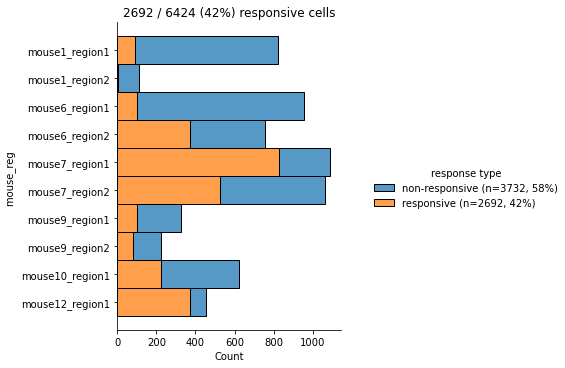

In [15]:
# # Compute % responsive cells as a function of nposthr
# nposthrs = np.arange(runs.max() + 2)
# pctresps = {k: np.zeros(nposthrs.size) for k in mouseregs}
# nresps_overall = np.zeros(nposthrs.size)
# for i, nposthr in enumerate(nposthrs):
#     isresproi = reclassify(stats.copy(), nposthr=nposthr)[Label.IS_RESP_ROI].groupby(
#         [Label.MOUSEREG, Label.ROI]).first()
#     for k, group in isresproi.groupby(Label.MOUSEREG):
#         nresps = group.sum()
#         pctresps[k][i] = nresps / len(group) * 100
#         nresps_overall[i] += nresps
# pctresps = pd.DataFrame(pctresps)
# if weighted:
#     pctresps_avg = nresps_overall / len(isresproi) * 100
# else:
#     pctresps_avg = pctresps.mean(axis=1)
# pctresp_critical = 50.
# nposthr_critical = np.interp(-pctresp_critical, -pctresps_avg, nposthrs)
# nposthr = np.round(nposthr_critical)
# logger.info(f'{pctresp_critical}% overall resonsiveness achieved with a threshold of {nposthr_critical:.1f} positive conditions')

# # Plot % responsive cells as a function of nposthr
# figs['pctresp_vs_nposthr'], ax = plt.subplots()
# ax.set_xlabel('threshold # pos conditions')
# ax.set_ylabel('% responding cells')
# for k, v in pctresps.items():
#     ax.plot(nposthrs, v, label=k)
# ax.plot(nposthrs, pctresps_avg, 'k', lw=3)
# ax.axhline(pctresp_critical, ls='--', c='k')
# ax.axvline(nposthr_critical, ls='--', c='k')
# sns.despine(ax=ax)
# ax.legend(bbox_to_anchor=(1.0, 1.0))

# Plot classification for default nposthr
figs['rtype_dist_per_mousereg'] = plot_cellcounts_by_type(stats, hue=Label.ROI_RESP_TYPE)

### Exclude specific datasets

In [16]:
to_exclude = [
    'mouse1_region2',
    'mouse9_region2',
    'mouse9_region2'
]
stats = exclude_datasets(stats.copy(), to_exclude)

 09/05/2022 19:40:43: excluding ['mouse1_region2', 'mouse9_region2', 'mouse9_region2'] datasets from analysis


### Parameter dependency curves

 09/05/2022 19:40:43: sub-indexing data...
 09/05/2022 19:40:43: filtering data...
 09/05/2022 19:40:43: cross-checking filters...
 09/05/2022 19:40:43: grouping by response type, grouping by mouse_reg, averaging and plotting mean peak post-stim Z(ΔF/F0) vs. P (MPa) ...


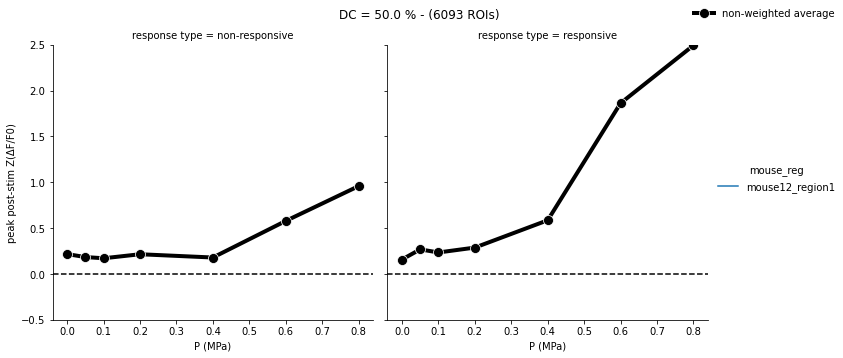

In [17]:
# # Compute max metrics per cell type as a function of nposthr
# ykeys = [Label.PEAK_ZSCORE_POSTSTIM]
# metrics_vs_nposthr = compute_metrics_vs_nposthr(stats, nposthrs, ykeys)

# # Plot metrics per dataset and response type as a function of nposthr
# for ykey in ykeys:
#     figs[f' max {ykey} vs nposthr'] = sns.relplot(
#         data=metrics_vs_nposthr,
#         kind='line',
#         x=Label.NPOS_CONDS,
#         y=ykey,
#         hue=Label.MOUSEREG,
#         hue_order=mouseregs,
#         col=Label.ROI_RESP_TYPE, 
#         col_order=get_default_rtypes()
#     ).figure

xkeys = [
    Label.P,
    # Label.DC,
]
ykeys = [Label.PEAK_ZSCORE_POSTSTIM]
# zthr = pvalue_to_zscore(.05)  # 1-sided
zthr = 1

# for n in np.arange(len(runs)) + 1:
stats2 = reclassify(stats, zthr=1, nposthr=5)
for xkey in xkeys:
    for ykey in ykeys:
        figs[f'{ykey}_vs_{xkey}'] = plot_parameter_dependency_across_datasets(
            stats2, xkey, ykey, baseline=0., weighted=weighted, ybounds=(-0.5, 2.5))
        # figs[f'{ykey}_vs_{xkey}'].suptitle(f'nposthr = {n}')

### Save figures

In [10]:
figsdir = get_figs_dir()  # Directory for output figures
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix='global')

 06/05/2022 13:48:10: saving figure "pctresp_vs_nposthr" on page 0
 06/05/2022 13:48:10: saving figure "rtype_dist_per_mousereg" on page 1
 06/05/2022 13:48:10: saving figure " max success rate vs nposthr" on page 2
 06/05/2022 13:48:10: saving figure " max Z(success rate) vs nposthr" on page 3
 06/05/2022 13:48:10: saving figure " max peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim] vs nposthr" on page 4
 06/05/2022 13:48:10: saving figure "success rate_vs_P (MPa)" on page 5
 06/05/2022 13:48:10: saving figure "Z(success rate)_vs_P (MPa)" on page 6
 06/05/2022 13:48:10: saving figure "peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]_vs_P (MPa)" on page 7
 06/05/2022 13:48:11: saving figure "success rate_vs_DC (%)" on page 8
 06/05/2022 13:48:11: saving figure "Z(success rate)_vs_DC (%)" on page 9
 06/05/2022 13:48:11: saving figure "peak post-stim [Z(ΔF/F0) - Z(ΔF/F0)_stim]_vs_DC (%)" on page 10
